In [1]:
import numpy as np
import codecs
from bs4 import BeautifulSoup as bs
import bs4
from nltk.tokenize import sent_tokenize, word_tokenize
import glob
import string
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy import stats
from collections import Counter
%matplotlib inline

# Parse FCE

In [2]:
def extract_error_c(elem):
    #if no embedded errors: return teacher and student version
    
    #try:
    #    typ = elem.NS['type']
        #print(typ)
    #except TypeError:
    #    pass
    
    teachersent =''
    studentsent =''

    if elem.find('c'):
        teachersent+=elem.c.getText()
    else:
        teachersent+=''

    if elem.find('i'):
        studentsent+=elem.i.getText()
    else:
        studentsent+=''
    return teachersent, studentsent

In [3]:
#Functions for parsing FCE corpus
def joinsents(old, new):
    new = new.strip()
    if len(old) == 0:
        joined =new
    elif old[-1] == ' ':
        if len(new) >0 and new[0] in string.punctuation:
            joined = old[:-1]+new
        else:
            joined = old+new    
    else:
        if len(new) > 0 and new[0] in string.punctuation:
            joined = old+new
        else:
            joined = ' '.join([old, new])
    return(joined)

def teacherversion(tag):
    #print(tag.name)
    if tag.name == 'i':
        #print('its an i')
        return []
    elif tag.name == 'c':
        #print('its a c')
        return tag
    elif tag.parent.name == 'NS' and tag.parent['type'][0] in ['M'] or tag.parent['type'] != 'CE':
        print('missing')
        return tag
    
def studentversion(tag):
    #print('tag', tag)
    #print('tagparent', tag.parent)
    if tag.name == 'c':
        #print('its an i')
        return []
    elif tag.name == 'i':
        #print('its a c')
        return tag
    elif tag.parent.name == 'NS':
        print(tag)
        if tag.parent['type'][0] not in ['M'] or tag.parent['type'] == 'CE':
            print('missing')
            return tag
        else:
            return []



In [4]:
path = "data/proficiency/"
textout = codecs.open(path+'fce_text', 'w', 'utf-8')
profout = codecs.open(path+'proficiency', 'w', 'utf-8')
firstlangout = codecs.open(path+'firstlang', 'w', 'utf-8')
docscoreout = codecs.open(path+'docscore', 'w', 'utf-8')

teachertextout = codecs.open(path+'fce_teacher', 'w', 'utf-8')
teacherprofout = codecs.open(path+'proficiency_teacher', 'w', 'utf-8')
teacherfirstlangout = codecs.open(path+'firstlang_teacher', 'w', 'utf-8')
langvec_t =[]
profvec_t =[]
docscorevec_t=[]
textvec_t = []
useridvec_t = []
ansvec_t = []


langvec_s =[]
profvec_s =[]
docscorevec_s=[]
textvec_s = []
useridvec_s = []
ansvec_s = [] 

for i, doc in enumerate(glob.glob(path+'fce-released-dataset/dataset/0100_2001_6/*xml')): #only test and validation
    print(i, doc)
    doc = codecs.open(doc, 'r', 'utf-8').read()
    soup = bs(doc, 'xml')

    firstlang = soup.language.string
    """if soup.age:  #Only around 30 out of 97 test documents have age
        agegroup=soup.age.string
    else:
        break
    """
    score=soup.score.string
    studentid=soup.head['sortkey']


    for ans in soup.find_all(['answer1', 'answer2']):
        docscore = ans.exam_score.string
        parag = ans.find_all('p')
        qnumber = ans.question_number.string
        student=""
        teacher=""
        for p in parag:
            for ch in p:
                if ch.find('NS') == -1 or type(ch.find('NS')) == int:#Then there are no errors in this bit
                    teacher = joinsents(teacher, ch)
                    student = joinsents(student, ch)
                else:
                    if ch.find('NS') and len(ch.find('NS')) > 0:
                        #print(ch)
                        for gr in ch.children:
                            if gr.find('NS') == -1:
                                #print(gr)
                                if not gr.find('i') or gr.find('c'):
                                    if gr.parent['type'] == 'CE' or gr.parent['type'][0] in ['R', 'U']:
                                        student = joinsents(student, gr)
                                    elif gr.parent['type'] in ['M']:
                                        teacher = joinsents(teacher, gr)
                                    else:
                                        teacher = joinsents(teacher, gr)
                                        student = joinsents(student, gr)
                                else:
                                    print('gr',gr)
                            else:
                                if gr.find('NS') and len(str(gr.find('NS'))) > 0:
                                    for ggc in gr.children:
                                        if ggc.find('NS') == -1:
                                            try:
                                                #print(ggc)
                                                if not ggc.find('i') or ggc.find('c'):
                                                    if ggc.parent.name=='NS' and ggc.parent['type'] == 'CE' or ggc.parent['type'][0] in ['R', 'U']:
                                                        student = joinsents(student, ggc)
                                                    elif ggc.parent['type'] in ['M']:
                                                        teacher = joinsents(teacher, ggc)
                                                    else:
                                                        teacher = joinsents(teacher, ggc)
                                                        student = joinsents(student, ggc)
                                                else:
                                                    print('ggc', ggc)
                                                    pass
                                            except KeyError:
                                                joinsents(teacher, ggc)
                                                joinsents(student, ggc) 

                                        elif ggc.find('NS') and len(ggc.find('NS')) > 0:
                                            for gggc in ggc.children:
                                                if gggc.find('NS') == -1:
                                                    try:
                                                        #print(ggc)
                                                        if not gggc.find('i') or gggc.find('c'):
                                                            if gggc.parent.name=='NS' and gggc.parent['type'] == 'CE' or gggc.parent['type'][0] in ['R', 'U']:
                                                                student = joinsents(student, gggc)
                                                            elif gggc.parent['type'] in ['M']:
                                                                teacher = joinsents(teacher, gggc)
                                                            else:
                                                                teacher = joinsents(teacher, gggc)
                                                                student = joinsents(student, gggc)
                                                        else:
                                                            print('gggc', gggc)
                                                            pass
                                                    except KeyError:
                                                        joinsents(teacher, gggc)
                                                        joinsents(student, gggc) 

                                        else: 
                                            t = ggc.find_all(teacherversion)
                                            t = ' '.join([c.text for c in t])
                                            teacher = joinsents(teacher, t)
                                            s = ggc.find_all(studentversion)
                                            s = ' '.join([i.text for i in s])
                                            student = joinsents(student, s)
                                else: #if part of certain errors in parent, only one of versions
                                    if gr.parent['type'] == 'CE' or gr.parent['type'] in ['R', 'U']:
                                        s = gr.find_all(studentversion)
                                        s = ' '.join([i.text for i in s])
                                        student = joinsents(student, s)

                                    elif gr.parent['type'] in ['M']:
                                        t = gr.find_all(teacherversion)
                                        t = ' '.join([c.text for c in t])
                                        teacher = joinsents(teacher, t)  
                                    else:
                                        s = gr.find_all(studentversion)
                                        s = ' '.join([i.text for i in s])
                                        student = joinsents(student, s)
                                        t = gr.find_all(teacherversion)
                                        t = ' '.join([c.text for c in t])
                                        teacher = joinsents(teacher, t)        

                    else:
                        if ch.name == 'NS' and not ch.i and not ch.c:
                            if ch['type'] == 'CE' or ch['type'][0] in ['R', 'U']:
                                student = joinsents(student, ch.get_text())
                            if ch['type'][0] in ['M']:
                                teacher = joinsents(teacher, ch.get_text())
                        else:
                            t = ch.find_all(teacherversion)
                            t = ' '.join([c.text for c in t])
                            teacher = joinsents(teacher, t)
                            s = ch.find_all(studentversion)
                            s = ' '.join([i.text for i in s])
                            student = joinsents(student, s)
        if firstlang and score and len(student)>50:
            studentsents = sent_tokenize(student)
            teachersents = sent_tokenize(teacher)
            for sent in studentsents:
                langvec_s.append(firstlang)
                profvec_s.append(float(score))
                docscorevec_s.append(float(docscore.strip('T')))
                textvec_s.append(sent)
                useridvec_s.append(studentid)
                ansvec_s.append(qnumber)
                textout.write(sent.strip('\n')+'\n')
                firstlangout.write(firstlang+'\t'+studentid+'\n')
                profout.write(score+'\t'+studentid+'\n')
                docscoreout.write(docscore+'\t'+studentid+'\n')
            for sent in teachersents:
                teachertextout.write(sent.strip('\n')+'\n')
                teacherfirstlangout.write(firstlang+'\t'+studentid+'\n')
                teacherprofout.write(score+'\t'+studentid+'\n')
                langvec_t.append(firstlang)
                profvec_t.append(float(score))
                docscorevec_t.append(float(docscore.strip('T')))
                textvec_t.append(sent)
                useridvec_t.append(studentid)
                ansvec_t.append(qnumber)
            
textout.close()
profout.close()
firstlangout.close()
docscoreout.close()
teachertextout.close()
teacherprofout.close()
teacherfirstlangout.close()

0 data/proficiency/fce-released-dataset/dataset/0100_2001_6/doc3002.xml
1 data/proficiency/fce-released-dataset/dataset/0100_2001_6/doc3176.xml
2 data/proficiency/fce-released-dataset/dataset/0100_2001_6/doc3163.xml
3 data/proficiency/fce-released-dataset/dataset/0100_2001_6/doc3003.xml
4 data/proficiency/fce-released-dataset/dataset/0100_2001_6/doc3038.xml
5 data/proficiency/fce-released-dataset/dataset/0100_2001_6/doc3158.xml
6 data/proficiency/fce-released-dataset/dataset/0100_2001_6/doc3171.xml
7 data/proficiency/fce-released-dataset/dataset/0100_2001_6/doc3005.xml
8 data/proficiency/fce-released-dataset/dataset/0100_2001_6/doc3039.xml
9 data/proficiency/fce-released-dataset/dataset/0100_2001_6/doc2906.xml
10 data/proficiency/fce-released-dataset/dataset/0100_2001_6/doc3006.xml
11 data/proficiency/fce-released-dataset/dataset/0100_2001_6/doc3061.xml
12 data/proficiency/fce-released-dataset/dataset/0100_2001_6/doc3288.xml
13 data/proficiency/fce-released-dataset/dataset/0100_2001_6/

# Statistical analysis of softmax predictions

## making df with predictions fce

In [5]:
teacher_version = False #corrected version of text or students version of text
alpha=0.05 #alphalevel for analysis
path = "data/proficiency/"
if teacher_version:
    preds = pd.read_csv(path+'teacher_preds_softmax.txt', sep=' ', names=['conf_0', 'conf_1'], header=None)
    langvec =langvec_t
    profvec =profvec_t
    docscorevec=docscorevec_t
    textvec = textvec_t
    useridvec = useridvec_t
    ansvec = ansvec_t
else:
    preds = pd.read_csv(path+'student_preds_softmax.txt', sep=' ', names=['conf_0', 'conf_1'], header=None)
    langvec =langvec_s
    profvec =profvec_s
    docscorevec=docscorevec_s
    textvec = textvec_s
    useridvec = useridvec_s
    ansvec = ansvec_s

In [6]:
print("number of sentences/documents", len(preds))
#len(preds)

number of sentences/documents 2511


In [7]:
fce = pd.DataFrame.from_dict({'first_lang':langvec[:len(preds)], 'score': profvec[:len(preds)], 'docscore': docscorevec[:len(preds)], 
                        'uid':useridvec[:len(preds)], 'qid': ansvec[:len(preds)]})
fce = pd.concat([fce, preds], axis=1)

### Binning softmax to binary!

In [8]:
fce.conf_0 = pd.cut(fce.conf_0, 2, labels=[0,1]).astype('float')

### Selcting subset for remaining tests

In [9]:
cut = 30 #set exam score cut for profiency.

#fake_pred = fce.loc[fce.conf_0>0.5] #only subset of sentences predicted to be fake 
#print(len(fake_pred)) #don't think we're going to use this

df = fce #set the dataset to either fce, fake_pred df is on sentence level

df_cut = df.loc[df.score>cut] #and also with a exam score cutoff

### group by author or answer

In [10]:
ansgr = df.groupby(['uid', 'qid','first_lang'], as_index=False).mean() #grouped by answer
authorgr = df.groupby(['uid', 'first_lang'], as_index=False).mean() #grouped by author

ansgr_cut = df.loc[df.score>cut].groupby(['uid', 'qid','first_lang'], as_index=False).mean() 
authorgr_cut = df.loc[df.score>cut].groupby(['uid', 'first_lang'], as_index=False).mean()

print("df number of datapoints:", len(df))
print("df_cut number of datapoints:", len(df_cut))
print("ansgr number of datapoints:", len(ansgr))
print("ansgr_cut number of datapoints:", len(ansgr_cut))
print("authorgr number of datapoints:", len(authorgr))
print("authorgr_cut number of datapoints:", len(authorgr_cut))

df number of datapoints: 2511
df_cut number of datapoints: 724
ansgr number of datapoints: 194
ansgr_cut number of datapoints: 54
authorgr number of datapoints: 97
authorgr_cut number of datapoints: 27


## First correlations (not much)

In [11]:
fake_pred.corr(method='pearson')

NameError: name 'fake_pred' is not defined

In [12]:
fce.corr(method='pearson') 

docscore     score    conf_0    conf_1
docscore  1.000000  0.876692  0.005216 -0.001978
score     0.876692  1.000000  0.015877 -0.009432
conf_0    0.005216  0.015877  1.000000 -0.883755
conf_1   -0.001978 -0.009432 -0.883755  1.000000

In [13]:
df.corr(method='pearson') 
print(stats.pearsonr(df.conf_0, df.score))

(0.015876917896031486, 0.4264713393619104)


In [14]:
df_cut.corr(method='pearson')
print(stats.pearsonr(df_cut.conf_0, df_cut.score))

(0.014741699283624858, 0.692108942080312)


## Correlating score and conf_0 for groups
#Significance test (second number in tuple is p-val)

In [15]:
print(stats.pearsonr(ansgr.conf_0, ansgr.score))
ansgr.corr(method='pearson')
#ansgr.corr(method='spearman')

(0.0525739217454765, 0.46658823983272646)


docscore     score    conf_0    conf_1
docscore  1.000000  0.872120  0.022252 -0.014026
score     0.872120  1.000000  0.052574 -0.032309
conf_0    0.022252  0.052574  1.000000 -0.918816
conf_1   -0.014026 -0.032309 -0.918816  1.000000

In [16]:
print(stats.pearsonr(ansgr_cut.conf_0, ansgr_cut.score))
ansgr_cut.corr(method='spearman')
ansgr_cut.corr(method='pearson') #for sentences above cut

(-0.010105255560229284, 0.9421861684707512)


docscore     score    conf_0    conf_1
docscore  1.000000  0.672513 -0.220784  0.227244
score     0.672513  1.000000 -0.010105  0.011568
conf_0   -0.220784 -0.010105  1.000000 -0.926889
conf_1    0.227244  0.011568 -0.926889  1.000000

In [17]:
print(stats.pearsonr(authorgr.conf_0, authorgr.score))
authorgr.corr(method='pearson')
#authorgr.corr(method='spearman')

(0.06245405493426591, 0.5433726281636391)


docscore     score    conf_0    conf_1
docscore  1.000000  0.964522  0.048550 -0.028857
score     0.964522  1.000000  0.062454 -0.037040
conf_0    0.048550  0.062454  1.000000 -0.923909
conf_1   -0.028857 -0.037040 -0.923909  1.000000

In [18]:
print(stats.pearsonr(authorgr_cut.conf_0, authorgr_cut.score))
authorgr_cut.corr(method='pearson') #for sentences above cut
#authorgr_cut.corr(method='spearman')

(0.046981815972064404, 0.8159934034104833)


docscore     score    conf_0    conf_1
docscore  1.000000  0.833136 -0.006067 -0.040364
score     0.833136  1.000000  0.046982 -0.047632
conf_0   -0.006067  0.046982  1.000000 -0.901854
conf_1   -0.040364 -0.047632 -0.901854  1.000000

## Correlating proficiency score with confidence within each language 

In [19]:
#all on sentence level
def correlate_prof_pred(dataframe):
    """Correlate profiency score with predictions for each language"""
    
    print("avg confidence of class 0 / fake",np.round(dataframe.conf_0.mean()*100, 2))
    #lang = pd.crosstab(fce['first_lang'],fce.conf_0).apply(lambda r: r/r.sum(), axis=1)
    corr = dataframe.groupby('first_lang').apply(lambda x: stats.pearsonr(x.conf_0, x.score))
    grouped = dataframe.groupby('first_lang').mean()
    grouped['r'] = corr.apply(lambda x: np.round(x[0],3))
    grouped['p'] = corr.apply(lambda x: np.round(x[1],3))
            
    #make latex table
    #latexdf=dataframe.groupby('first_lang').mean().loc[:,['conf_0' ]].sort_values(by='conf_0', ascending=False)
    latexdf = grouped.loc[:,['conf_0', 'r', 'p']].sort_values(by='conf_0', ascending=False)
    latexdf['n'] = dataframe.groupby('first_lang').score.count()  #adding support for each first_lang
    latexdf.conf_0 = np.round(latexdf.conf_0*100,2)
    latexdf.dropna(inplace=True)
    print(latexdf[['conf_0', 'r', 'n', 'p']].to_latex())

In [20]:
#only above cut
#Correlating proficiency score with confidence for each language above cut
correlate_prof_pred(fce)

avg confidence of class 0 / fake 65.63
\begin{tabular}{lrrrr}
\toprule
{} &  conf\_0 &      r &    n &      p \\
first\_lang &         &        &      &        \\
\midrule
Turkish    &   73.15 & -0.149 &  108 &  0.124 \\
German     &   70.08 &  0.087 &  264 &  0.160 \\
Japanese   &   69.10 & -0.083 &  178 &  0.270 \\
Thai       &   68.93 &  0.001 &  206 &  0.987 \\
Russian    &   65.49 &  0.003 &  142 &  0.969 \\
Italian    &   65.25 &  0.003 &  118 &  0.971 \\
Polish     &   65.14 & -0.076 &  109 &  0.430 \\
French     &   64.98 & -0.014 &  277 &  0.820 \\
Catalan    &   64.94 &  0.034 &  174 &  0.653 \\
Chinese    &   64.90 &  0.059 &  302 &  0.311 \\
Spanish    &   63.73 & -0.025 &  204 &  0.720 \\
Korean     &   60.26 &  0.027 &  234 &  0.680 \\
Greek      &   59.15 &  0.052 &  164 &  0.507 \\
\bottomrule
\end{tabular}



/Users/Terne/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [21]:
correlate_prof_pred(fce_cut)

NameError: name 'fce_cut' is not defined

In [22]:
correlate_prof_pred(df)

avg confidence of class 0 / fake 65.63
\begin{tabular}{lrrrr}
\toprule
{} &  conf\_0 &      r &    n &      p \\
first\_lang &         &        &      &        \\
\midrule
Turkish    &   73.15 & -0.149 &  108 &  0.124 \\
German     &   70.08 &  0.087 &  264 &  0.160 \\
Japanese   &   69.10 & -0.083 &  178 &  0.270 \\
Thai       &   68.93 &  0.001 &  206 &  0.987 \\
Russian    &   65.49 &  0.003 &  142 &  0.969 \\
Italian    &   65.25 &  0.003 &  118 &  0.971 \\
Polish     &   65.14 & -0.076 &  109 &  0.430 \\
French     &   64.98 & -0.014 &  277 &  0.820 \\
Catalan    &   64.94 &  0.034 &  174 &  0.653 \\
Chinese    &   64.90 &  0.059 &  302 &  0.311 \\
Spanish    &   63.73 & -0.025 &  204 &  0.720 \\
Korean     &   60.26 &  0.027 &  234 &  0.680 \\
Greek      &   59.15 &  0.052 &  164 &  0.507 \\
\bottomrule
\end{tabular}



/Users/Terne/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [23]:
correlate_prof_pred(authorgr)

avg confidence of class 0 / fake 65.14
\begin{tabular}{lrrrr}
\toprule
{} &  conf\_0 &      r &   n &      p \\
first\_lang &         &        &     &        \\
\midrule
Turkish    &   73.58 & -0.518 &   4 &  0.482 \\
German     &   70.29 &  0.418 &   9 &  0.262 \\
Thai       &   69.33 & -0.058 &   8 &  0.892 \\
Japanese   &   67.80 & -0.336 &   7 &  0.461 \\
Italian    &   66.64 &  0.023 &   5 &  0.971 \\
Russian    &   65.70 & -0.028 &   6 &  0.958 \\
Catalan    &   65.45 & -0.007 &   8 &  0.986 \\
French     &   64.54 & -0.124 &  12 &  0.701 \\
Polish     &   64.03 & -0.301 &   4 &  0.699 \\
Chinese    &   63.73 &  0.211 &   9 &  0.586 \\
Spanish    &   61.39 &  0.090 &  10 &  0.805 \\
Korean     &   59.41 &  0.148 &   8 &  0.726 \\
Greek      &   58.46 &  0.120 &   6 &  0.820 \\
\bottomrule
\end{tabular}



/Users/Terne/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [24]:
correlate_prof_pred(ansgr)

avg confidence of class 0 / fake 64.89
\begin{tabular}{lrrrr}
\toprule
{} &  conf\_0 &      r &   n &      p \\
first\_lang &         &        &     &        \\
\midrule
Turkish    &   74.40 & -0.350 &   8 &  0.396 \\
German     &   69.55 &  0.291 &  18 &  0.241 \\
Thai       &   69.24 & -0.040 &  16 &  0.882 \\
Japanese   &   68.62 & -0.177 &  14 &  0.546 \\
Italian    &   66.07 &  0.052 &  10 &  0.888 \\
Russian    &   65.15 & -0.041 &  12 &  0.900 \\
Catalan    &   64.92 &  0.020 &  16 &  0.941 \\
French     &   64.47 & -0.032 &  24 &  0.883 \\
Chinese    &   63.91 &  0.184 &  18 &  0.465 \\
Polish     &   62.68 & -0.297 &   8 &  0.475 \\
Spanish    &   60.54 &  0.096 &  20 &  0.687 \\
Korean     &   59.09 &  0.070 &  16 &  0.796 \\
Greek      &   58.48 &  0.082 &  12 &  0.799 \\
\bottomrule
\end{tabular}



/Users/Terne/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [25]:
correlate_prof_pred(ansgr_cut) #to few

avg confidence of class 0 / fake 65.74
\begin{tabular}{lrrrr}
\toprule
{} &  conf\_0 &      r &   n &      p \\
first\_lang &         &        &     &        \\
\midrule
Thai       &   71.73 &  0.382 &   4 &  0.618 \\
German     &   70.81 &  0.228 &   8 &  0.588 \\
Catalan    &   68.33 &  0.642 &   4 &  0.358 \\
Spanish    &   67.19 & -0.562 &   4 &  0.438 \\
French     &   66.48 & -0.204 &  10 &  0.573 \\
Japanese   &   66.39 & -0.214 &   4 &  0.786 \\
Chinese    &   62.74 &  0.745 &   6 &  0.089 \\
Korean     &   56.93 & -0.033 &   6 &  0.951 \\
\bottomrule
\end{tabular}



/Users/Terne/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [26]:
correlate_prof_pred(authorgr_cut) #to few

avg confidence of class 0 / fake 65.75
\begin{tabular}{lrrrr}
\toprule
{} &  conf\_0 &      r &  n &      p \\
first\_lang &         &        &    &        \\
\midrule
Thai       &   72.04 &  1.000 &  2 &  0.000 \\
German     &   71.41 &  0.885 &  4 &  0.115 \\
Catalan    &   67.88 &  1.000 &  2 &  0.000 \\
Spanish    &   67.85 & -1.000 &  2 &  0.000 \\
French     &   65.81 & -0.449 &  5 &  0.449 \\
Japanese   &   64.43 & -1.000 &  2 &  0.000 \\
Chinese    &   62.08 &  0.944 &  3 &  0.213 \\
Korean     &   57.63 & -0.174 &  3 &  0.888 \\
\bottomrule
\end{tabular}



/Users/Terne/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


## First languages

### Significance test of first language groups 
Check whether conf_0 of sentences/authors/answers one lang and rest of set are from the same distribution

In [27]:
def firstlang_latex(dataframe):
    """Runs independent t-test of first languages with mean higher than grand mean.
    Prints language if significant
    Prints a latex table from a dataframe"""
    print("avg conf_0:",np.round(dataframe.conf_0.mean()*100,2))
    only_above =dataframe.groupby('first_lang').apply(lambda x: x.conf_0.mean() > dataframe.conf_0.mean())
    for lang in only_above.index:
        if only_above.loc[lang] == True: #if group mean is higher than grand mean
            one_lang=dataframe.loc[dataframe.first_lang==gr, 'conf_0']
            rest = dataframe.loc[dataframe.first_lang!=gr, 'conf_0']
            ttestres = stats.ttest_ind(one_lang, rest)
            if ttestres[1] <= alpha: #check pval:
                print("sign.", gr, ttestres)

    #make latex table
    latexdf=dataframe.groupby('first_lang').mean().loc[:,['conf_0' ]].sort_values(by='conf_0', ascending=False)
    latexdf['n'] = dataframe.groupby('first_lang').score.count()  #adding support for each first_lang
    latexdf.conf_0 = np.round(latexdf.conf_0*100, 2)
    print(latexdf.to_latex())

In [28]:
 #sentence level
firstlang_latex(fce)

avg conf_0: 65.63
\begin{tabular}{lrr}
\toprule
{} &  conf\_0 &    n \\
first\_lang &         &      \\
\midrule
Turkish    &   73.15 &  108 \\
German     &   70.08 &  264 \\
Japanese   &   69.10 &  178 \\
Thai       &   68.93 &  206 \\
Portuguese &   67.74 &   31 \\
Russian    &   65.49 &  142 \\
Italian    &   65.25 &  118 \\
Polish     &   65.14 &  109 \\
French     &   64.98 &  277 \\
Catalan    &   64.94 &  174 \\
Chinese    &   64.90 &  302 \\
Spanish    &   63.73 &  204 \\
Korean     &   60.26 &  234 \\
Greek      &   59.15 &  164 \\
\bottomrule
\end{tabular}



In [29]:
#sentence level cut off 
firstlang_latex(fce_cut)

NameError: name 'fce_cut' is not defined

In [30]:
firstlang_latex(ansgr)

avg conf_0: 64.89
\begin{tabular}{lrr}
\toprule
{} &  conf\_0 &   n \\
first\_lang &         &     \\
\midrule
Turkish    &   74.40 &   8 \\
German     &   69.55 &  18 \\
Thai       &   69.24 &  16 \\
Japanese   &   68.62 &  14 \\
Portuguese &   67.50 &   2 \\
Italian    &   66.07 &  10 \\
Russian    &   65.15 &  12 \\
Catalan    &   64.92 &  16 \\
French     &   64.47 &  24 \\
Chinese    &   63.91 &  18 \\
Polish     &   62.68 &   8 \\
Spanish    &   60.54 &  20 \\
Korean     &   59.09 &  16 \\
Greek      &   58.48 &  12 \\
\bottomrule
\end{tabular}



In [31]:
#grouped by answer cut off
firstlang_latex(ansgr_cut)

avg conf_0: 65.74
\begin{tabular}{lrr}
\toprule
{} &  conf\_0 &   n \\
first\_lang &         &     \\
\midrule
Thai       &   71.73 &   4 \\
German     &   70.81 &   8 \\
Catalan    &   68.33 &   4 \\
Russian    &   68.27 &   2 \\
Italian    &   68.18 &   2 \\
Spanish    &   67.19 &   4 \\
French     &   66.48 &  10 \\
Japanese   &   66.39 &   4 \\
Polish     &   65.28 &   2 \\
Chinese    &   62.74 &   6 \\
Korean     &   56.93 &   6 \\
Greek      &   51.30 &   2 \\
\bottomrule
\end{tabular}



In [32]:
firstlang_latex(authorgr)

avg conf_0: 65.14
\begin{tabular}{lrr}
\toprule
{} &  conf\_0 &   n \\
first\_lang &         &     \\
\midrule
Turkish    &   73.58 &   4 \\
German     &   70.29 &   9 \\
Thai       &   69.33 &   8 \\
Japanese   &   67.80 &   7 \\
Portuguese &   67.74 &   1 \\
Italian    &   66.64 &   5 \\
Russian    &   65.70 &   6 \\
Catalan    &   65.45 &   8 \\
French     &   64.54 &  12 \\
Polish     &   64.03 &   4 \\
Chinese    &   63.73 &   9 \\
Spanish    &   61.39 &  10 \\
Korean     &   59.41 &   8 \\
Greek      &   58.46 &   6 \\
\bottomrule
\end{tabular}



In [33]:
firstlang_latex(authorgr_cut)

avg conf_0: 65.75
\begin{tabular}{lrr}
\toprule
{} &  conf\_0 &  n \\
first\_lang &         &    \\
\midrule
Thai       &   72.04 &  2 \\
German     &   71.41 &  4 \\
Russian    &   68.97 &  1 \\
Italian    &   68.18 &  1 \\
Polish     &   68.00 &  1 \\
Catalan    &   67.88 &  2 \\
Spanish    &   67.85 &  2 \\
French     &   65.81 &  5 \\
Japanese   &   64.43 &  2 \\
Chinese    &   62.08 &  3 \\
Korean     &   57.63 &  3 \\
Greek      &   52.00 &  1 \\
\bottomrule
\end{tabular}



# Old drafts

In [34]:
o_22_mean = fce_o_22 = fce.loc[fce.score>25]
print(1-fce_o_22.y_pred.mean())
lang_o_22 = pd.crosstab(fce_o_22['first_lang'],fce_o_22['y_pred']).apply(lambda r: r/r.sum(), axis=1)
lang_o_22.sort_values(by=0, inplace=True, ascending=False)
only_above_22 = lang_o_22[lang_o_22[0] > 1-fce_o_22.y_pred.mean() ]
latex = pd.DataFrame(lang_o_22[0]-(1-fce_o_22.y_pred.mean()))
latex['n'] = fce_o_22.groupby('first_lang').y_pred.count()
latex[0] = np.round(latex[0]*100, 2)
print(latex.to_latex())

AttributeError: 'DataFrame' object has no attribute 'y_pred'

In [299]:
for row in only_above_22.iterrows():
    lang = row[0]
    firstlang=fce_o_22.loc[fce_o_22.first_lang==lang,'y_pred']
    rest=fce_o_22.loc[fce_o_22.first_lang!=lang, 'y_pred'] # no use entire dataset
    print(lang, stats.ttest_ind(firstlang, fce_o_22.y_pred))

Japanese Ttest_indResult(statistic=-2.2673238780205525, pvalue=0.02350360555900753)
Catalan Ttest_indResult(statistic=-0.8934968342393913, pvalue=0.3717242897017409)
German Ttest_indResult(statistic=-0.9763721077824633, pvalue=0.3290164462660622)
Korean Ttest_indResult(statistic=-0.748550747598632, pvalue=0.4542343909175969)
Thai Ttest_indResult(statistic=-0.6622410262608136, pvalue=0.5079076506301841)
Polish Ttest_indResult(statistic=-0.10487411267404996, pvalue=0.9164889700254893)
Russian Ttest_indResult(statistic=-0.126484734824959, pvalue=0.899363793344616)
Italian Ttest_indResult(statistic=-0.04173408751822397, pvalue=0.9667158512465552)


In [284]:
print(fce_o_22.y_pred.mean())
Counter(fce_o_22.first_lang)

0.45454545454545453


Counter({'Japanese': 59,
         'Greek': 78,
         'Russian': 96,
         'French': 256,
         'Korean': 117,
         'Chinese': 250,
         'Catalan': 77,
         'Spanish': 119,
         'German': 194,
         'Italian': 73,
         'Thai': 141,
         'Turkish': 33,
         'Polish': 47})

In [317]:
fce.groupby('first_lang').score.mean()

first_lang
Catalan       27.398876
Chinese       28.198052
French        30.460714
German        29.711610
Greek         26.115854
Italian       25.323077
Japanese      26.807018
Korean        26.352423
Polish        27.100000
Portuguese    25.000000
Russian       28.903448
Spanish       26.187793
Thai          28.127358
Turkish       24.371681
Name: score, dtype: float64

In [318]:
fce.groupby('first_lang').score.std()

first_lang
Catalan       6.188508
Chinese       5.773950
French        4.205121
German        5.588251
Greek         6.503797
Italian       3.040337
Japanese      5.362523
Korean        7.966136
Polish        5.601360
Portuguese    0.000000
Russian       5.121203
Spanish       7.711327
Thai          5.207341
Turkish       1.324189
Name: score, dtype: float64

In [ ]:
 #langvec =langvec_s
   # profvec =profvec_s
  #  docscorevec=docscorevec_s
  #  textvec = textvec_s
  #  useridvec = useridvec_s
  #  ansvec = ansvec_s

In [34]:
path = "data/proficiency/"
teacher_preds = pd.read_csv(path+'teacher_preds_softmax.txt', sep=' ', names=['conf_0', 'conf_1'], header=None)
student_preds = pd.read_csv(path+'student_preds_softmax.txt', sep=' ', names=['conf_0', 'conf_1'], header=None)

1590
921
1606
943


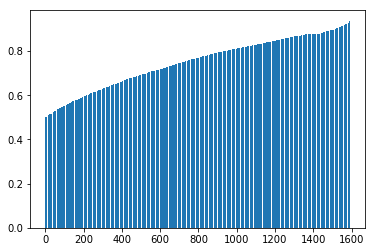

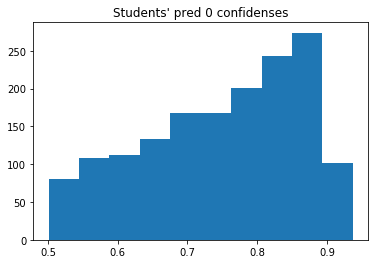

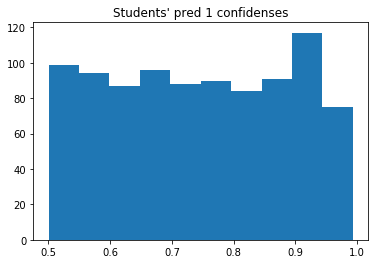

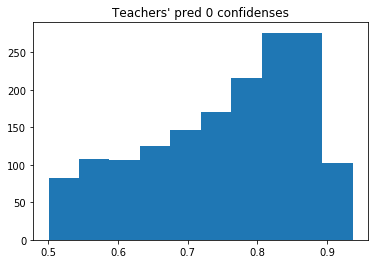

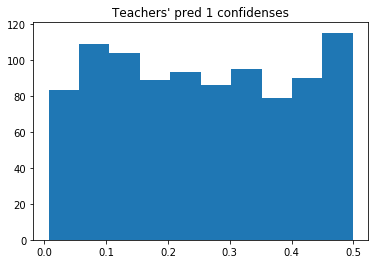

In [35]:
student_preds_0 = student_preds[student_preds.conf_1 < 0.5]
print(len(student_preds_0))
student_preds_1 = student_preds[student_preds.conf_1 >=0.5]
print(len(student_preds_1))
teacher_preds_0 = teacher_preds[teacher_preds.conf_1 < 0.5]
print(len(teacher_preds_0))
teacher_preds_1 = teacher_preds[teacher_preds.conf_1 >=0.5]
print(len(teacher_preds_1))

plt.bar(list(range(1,len(student_preds_0.conf_0)+1)),sorted(student_preds_0.conf_0))
plt.show()
plt.hist(sorted(student_preds_0.conf_0))
plt.title("Students' pred 0 confidenses")
plt.show()
plt.hist(sorted(student_preds_1.conf_1))
plt.title("Students' pred 1 confidenses")
plt.show()
plt.hist(sorted(teacher_preds_0.conf_0))
plt.title("Teachers' pred 0 confidenses")
plt.show()
plt.hist(sorted(teacher_preds_1.conf_0))
plt.title("Teachers' pred 1 confidenses")
plt.show()

In [36]:
len(sorted(student_preds_0.conf_0))

1590

In [37]:
d_stu = {"score": profvec_s[:len(student_preds)], "docscore":docscorevec_s[:len(student_preds)], 
         "ID":useridvec_s[:len(student_preds)], "first_lang":langvec_s[:len(student_preds)]}

In [38]:
df_stu = pd.DataFrame(d_stu)
print(len(df_stu))
print(len(student_preds))
df_stu = pd.concat([df_stu, student_preds], axis=1)

2511
2511


In [39]:
abs_diff = pd.DataFrame(np.absolute(df_stu.conf_0 - df_stu.conf_1), columns=["abs_diff"])

In [40]:
df_stu = pd.concat([df_stu, abs_diff], axis=1)

In [41]:
df_stu.head()

ID  docscore first_lang  score    conf_0    conf_1  abs_diff
0  TE23*0100*2001*01       3.1    Spanish   21.0  0.822006  0.177994  0.644011
1  TE23*0100*2001*01       3.1    Spanish   21.0  0.822248  0.177752  0.644497
2  TE23*0100*2001*01       3.1    Spanish   21.0  0.200748  0.799252  0.598504
3  TE23*0100*2001*01       3.1    Spanish   21.0  0.203175  0.796825  0.593651
4  TE23*0100*2001*01       3.1    Spanish   21.0  0.877065  0.122935  0.754131

In [42]:
# Sort away sentences where the confidence is low:
#df_stu = df_stu[df_stu.abs_diff > 0.25]
# Sort away those with the lowest scores:
#df_stu = df_stu[df_stu.score >30]

In [43]:
len(df_stu)

2511

In [44]:
#df_stu.groupby('lang').conf_0.mean()

In [45]:
correlate_prof_pred(df_stu)

avg confidence of class 0 / fake 56.81
\begin{tabular}{lrrrr}
\toprule
{} &  conf\_0 &      r &    n &      p \\
first\_lang &         &        &      &        \\
\midrule
Turkish    &   60.46 & -0.121 &  108 &  0.212 \\
Japanese   &   59.61 & -0.082 &  178 &  0.275 \\
German     &   59.53 &  0.092 &  264 &  0.138 \\
Thai       &   59.09 & -0.029 &  206 &  0.677 \\
Italian    &   57.05 &  0.007 &  118 &  0.938 \\
Catalan    &   56.55 &  0.043 &  174 &  0.577 \\
Russian    &   56.31 &  0.044 &  142 &  0.605 \\
French     &   55.93 & -0.030 &  277 &  0.615 \\
Chinese    &   55.85 &  0.051 &  302 &  0.374 \\
Polish     &   55.71 & -0.032 &  109 &  0.743 \\
Spanish    &   55.42 & -0.052 &  204 &  0.459 \\
Korean     &   54.50 &  0.006 &  234 &  0.923 \\
Greek      &   53.17 &  0.062 &  164 &  0.430 \\
\bottomrule
\end{tabular}



/Users/Terne/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [46]:
chinese = df_stu[df_stu.first_lang=="Chinese"]

SpearmanrResult(correlation=0.02730047723897006, pvalue=0.6365325870451977)


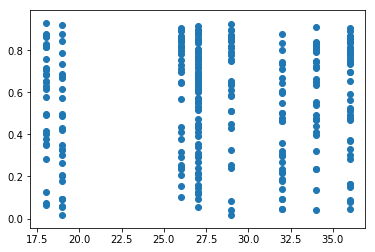

In [47]:
plt.scatter(chinese.score, chinese.conf_0)
print(stats.spearmanr(chinese.score,chinese.conf_0))
#print(stats.pearsonr(chinese.score,chinese.conf_0))

SpearmanrResult(correlation=0.04032936408254338, pvalue=0.48503503190743813)

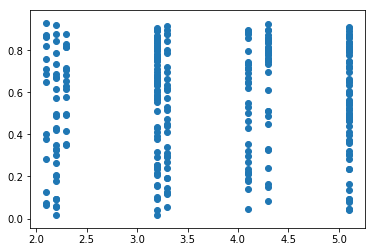

In [48]:
plt.scatter(chinese.docscore, chinese.conf_0)
stats.spearmanr(chinese.docscore,chinese.conf_0)

In [49]:
def correlate_prof_pred_docscore(dataframe):
    """Correlate profiency score with predictions for each language"""
    
    print("avg confidence of class 0 / fake",np.round(dataframe.conf_0.mean()*100, 2))
    #lang = pd.crosstab(fce['first_lang'],fce.conf_0).apply(lambda r: r/r.sum(), axis=1)
    corr = dataframe.groupby('first_lang').apply(lambda x: stats.pearsonr(x.conf_0, x.docscore))
    grouped = dataframe.groupby('first_lang').mean()
    grouped['r'] = corr.apply(lambda x: np.round(x[0],3))
    grouped['p'] = corr.apply(lambda x: np.round(x[1],3))
            
    #make latex table
    #latexdf=dataframe.groupby('first_lang').mean().loc[:,['conf_0' ]].sort_values(by='conf_0', ascending=False)
    latexdf = grouped.loc[:,['conf_0', 'r', 'p']].sort_values(by='conf_0', ascending=False)
    latexdf['n'] = dataframe.groupby('first_lang').docscore.count()  #adding support for each first_lang
    latexdf.conf_0 = np.round(latexdf.conf_0*100,2)
    latexdf.dropna(inplace=True)
    print(latexdf[['conf_0', 'r', 'n', 'p']].to_latex())

In [50]:
authorgr = df_stu.groupby(['ID'], as_index=False).mean() #grouped by author
authorgr

ID  docscore  score    conf_0    conf_1  abs_diff
0    TE1*0100*2001*01  3.588889   30.0  0.490703  0.509297  0.479610
1   TE10*0100*2001*01  3.200000   26.0  0.604944  0.395056  0.529331
2   TE11*0100*2001*01  2.748000   23.0  0.550218  0.449782  0.492673
3   TE12*0100*2001*01  3.750000   26.0  0.558114  0.441886  0.485700
4   TE13*0100*2001*01  3.300000   26.0  0.650936  0.349064  0.517442
5   TE14*0100*2001*01  5.155172   38.0  0.599983  0.400017  0.471035
6   TE15*0100*2001*01  3.281818   27.0  0.605617  0.394383  0.478153
7   TE16*0100*2001*01  5.144000   39.0  0.524532  0.475468  0.479451
8   TE17*0100*2001*01  2.700000   25.0  0.629212  0.370788  0.579541
9   TE18*0100*2001*01  2.253846   24.0  0.642796  0.357204  0.461920
10  TE19*0100*2001*01  2.700000   25.0  0.622758  0.377242  0.449751
11   TE2*0100*2001*01  3.300000   27.0  0.485632  0.514368  0.459378
12  TE20*0100*2001*01  3.722222   30.0  0.466119  0.533881  0.507363
13  TE21*0100*2001*01  3.582500   27.0  0.639120  0.360880  0.443340
14  TE22*0100*2001*01  2.663636   20.0  0.598602  0.401398  0.454190
15  TE23*0100*2001*01  2.650000   21.0  0.446044  0.553956  0.577335
16  TE24*0100*2001*01  2.700000   21.0  0.535732  0.464268  0.472125
17  TE25*0100*2001*01  3.200000   26.0  0.500376  0.499624  0.479015
18  TE26*0100*2001*01  2.750000   22.0  0.534154  0.465846  0.562213
19  TE27*0100*2001*01  2.746154   24.0  0.557075  0.442925  0.494450
20  TE28*0100*2001*01  5.200000   38.0  0.514157  0.485843  0.551781
21  TE29*0100*2001*01  3.644444   30.0  0.459462  0.540538  0.499776
22   TE3*0100*2001*01  5.100000   34.0  0.535054  0.464946  0.533529
23  TE30*0100*2001*01  3.188000   24.0  0.550997  0.449003  0.507254
24  TE31*0100*2001*01  2.740000   23.0  0.519057  0.480943  0.399120
25  TE32*0100*2001*01  2.700000   22.0  0.630136  0.369864  0.541014
26  TE33*0100*2001*01  2.576190   23.0  0.576341  0.423659  0.490203
27  TE34*0100*2001*01  5.200000   39.0  0.504656  0.495344  0.527264
28  TE35*0100*2001*01  4.786957   34.0  0.583091  0.416909  0.458267
29  TE36*0100*2001*01  5.154839   37.0  0.644555  0.355445  0.534147
..                ...       ...    ...       ...       ...       ...
67  TE70*0100*2001*01  3.200000   26.0  0.546939  0.453062  0.413809
68  TE71*0100*2001*01  2.071875   21.0  0.612515  0.387485  0.463146
69  TE72*0100*2001*01  5.190909   38.0  0.557340  0.442660  0.531282
70  TE73*0100*2001*01  4.196296   32.0  0.540137  0.459863  0.407285
71  TE74*0100*2001*01  3.617857   29.0  0.674224  0.325776  0.517323
72  TE75*0100*2001*01  5.200000   36.0  0.555660  0.444340  0.546118
73  TE76*0100*2001*01  5.244828   40.0  0.611720  0.388280  0.497190
74  TE77*0100*2001*01  3.680952   29.0  0.510103  0.489897  0.552024
75  TE78*0100*2001*01  5.100000   34.0  0.581169  0.418831  0.407180
76  TE79*0100*2001*01  5.181481   36.0  0.602386  0.397614  0.558534
77   TE8*0100*2001*01  2.783871   25.0  0.593429  0.406571  0.535779
78  TE80*0100*2001*01  5.157692   37.0  0.503597  0.496403  0.449407
79  TE81*0100*2001*01  2.100000   17.0  0.549134  0.450866  0.489580
80  TE82*0100*2001*01  4.551613   32.0  0.425544  0.574456  0.442031
81  TE83*0100*2001*01  3.100000   25.0  0.580558  0.419442  0.440271
82  TE84*0100*2001*01  3.126087   25.0  0.515904  0.484096  0.569400
83  TE85*0100*2001*01  4.744444   36.0  0.598681  0.401319  0.484666
84  TE86*0100*2001*01  3.827586   31.0  0.548637  0.451363  0.485166
85  TE87*0100*2001*01  3.200000   27.0  0.532767  0.467233  0.495471
86  TE88*0100*2001*01  2.200000   19.0  0.420423  0.579577  0.497860
87  TE89*0100*2001*01  3.678947   28.0  0.634846  0.365154  0.509019
88   TE9*0100*2001*01  3.100000   24.0  0.475619  0.524381  0.488042
89  TE90*0100*2001*01  2.254167   20.0  0.474215  0.525785  0.554665
90  TE91*0100*2001*01  2.814286   25.0  0.597448  0.402552  0.552958
91  TE92*0100*2001*01  2.671429   23.0  0.583726  0.416274  0.439978
92  TE93*0100*2001*01  2.690909   22.0  0.586268  0.413732  0.362774
93  TE94*0100*200

In [51]:
#stats.spearmanr(chinese.score,chinese.conf_0)

In [52]:
stats.spearmanr(authorgr.score, authorgr.conf_0)

SpearmanrResult(correlation=0.010242916172210995, pvalue=0.9206810780758847)

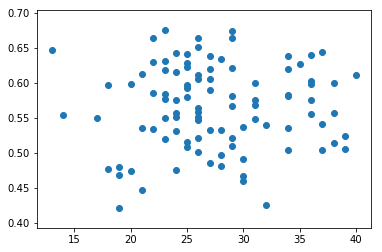

In [53]:
plt.scatter(authorgr.score, authorgr.conf_0)

In [54]:
stats.spearmanr(authorgr.docscore, authorgr.conf_0)

SpearmanrResult(correlation=0.005121832551365279, pvalue=0.960289274822304)

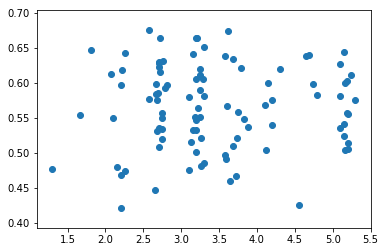

In [55]:
plt.scatter(authorgr.docscore, authorgr.conf_0)

In [56]:
authorgr = df_stu.groupby(['ID'], as_index=False).mean() #grouped by author
author_and_lang = df_stu.groupby(['ID', "first_lang"], as_index=False).mean() #grouped by author and lang
author_and_lang.first_lang.unique()

array(['French', 'Chinese', 'Italian', 'Japanese', 'Russian', 'Thai',
       'Greek', 'Turkish', 'Spanish', 'Catalan', 'German', 'Korean',
       'Polish', 'Portuguese'], dtype=object)

In [432]:
author_and_lang

ID  first_lang  docscore  score    conf_0    conf_1  \
0    TE1*0100*2001*01      French  3.588889   30.0  0.490703  0.509297   
1   TE10*0100*2001*01     Chinese  3.200000   26.0  0.604944  0.395056   
2   TE11*0100*2001*01     Italian  2.748000   23.0  0.550218  0.449782   
3   TE12*0100*2001*01    Japanese  3.750000   26.0  0.558114  0.441886   
4   TE13*0100*2001*01     Italian  3.300000   26.0  0.650936  0.349064   
5   TE14*0100*2001*01     Russian  5.155172   38.0  0.599983  0.400017   
6   TE15*0100*2001*01        Thai  3.281818   27.0  0.605617  0.394383   
7   TE16*0100*2001*01       Greek  5.144000   39.0  0.524532  0.475468   
8   TE17*0100*2001*01      French  2.700000   25.0  0.629212  0.370788   
9   TE18*0100*2001*01    Japanese  2.253846   24.0  0.642796  0.357204   
10  TE19*0100*2001*01     Turkish  2.700000   25.0  0.622758  0.377242   
11   TE2*0100*2001*01     Chinese  3.300000   27.0  0.485632  0.514368   
12  TE20*0100*2001*01        Thai  3.722222   30.0  0.466119  0.533881   
13  TE21*0100*2001*01     Chinese  3.582500   27.0  0.639120  0.360880   
14  TE22*0100*2001*01        Thai  2.663636   20.0  0.598602  0.401398   
15  TE23*0100*2001*01     Spanish  2.650000   21.0  0.446044  0.553956   
16  TE24*0100*2001*01       Greek  2.700000   21.0  0.535732  0.464268   
17  TE25*0100*2001*01      French  3.200000   26.0  0.500376  0.499624   
18  TE26*0100*2001*01     Spanish  2.750000   22.0  0.534154  0.465846   
19  TE27*0100*2001*01     Catalan  2.746154   24.0  0.557075  0.442925   
20  TE28*0100*2001*01     Spanish  5.200000   38.0  0.514157  0.485843   
21  TE29*0100*2001*01     Catalan  3.644444   30.0  0.459462  0.540538   
22   TE3*0100*2001*01     Catalan  5.100000   34.0  0.535054  0.464946   
23  TE30*0100*2001*01     Russian  3.188000   24.0  0.550997  0.449003   
24  TE31*0100*2001*01     Catalan  2.740000   23.0  0.519057  0.480943   
25  TE32*0100*2001*01    Japanese  2.700000   22.0  0.630136  0.369864   
26  TE33*0100*2001*01     Turkish  2.576190   23.0  0.576341  0.423659   
27  TE34*0100*2001*01      French  5.200000   39.0  0.504656  0.495344   
28  TE35*0100*2001*01    Japanese  4.786957   34.0  0.583091  0.416909   
29  TE36*0100*2001*01        Thai  5.154839   37.0  0.644555  0.355445   
..                ...         ...       ...    ...       ...       ...   
67  TE70*0100*2001*01       Greek  3.200000   26.0  0.546939  0.453062   
68  TE71*0100*2001*01      Polish  2.071875   21.0  0.612515  0.387485   
69  TE72*0100*2001*01    Japanese  5.190909   38.0  0.557340  0.442660   
70  TE73*0100*2001*01        Thai  4.196296   32.0  0.540137  0.459863   
71  TE74*0100*2001*01      German  3.617857   29.0  0.674224  0.325776   
72  TE75*0100*2001*01      French  5.200000   36.0  0.555660  0.444340   
73  TE76*0100*2001*01      German  5.244828   40.0  0.611720  0.388280   
74  TE77*0100*2001*01      French  3.680952   29.0  0.510103  0.489897   
75  TE78*0100*2001*01     Chinese  5.100000   34.0  0.581169  0.418831   
76  TE79*0100*2001*01      German  5.181481   36.0  0.602386  0.397614   
77   TE8*0100*2001*01  Portuguese  2.783871   25.0  0.593429  0.406571   
78  TE80*0100*2001*01      Korean  5.157692   37.0  0.503597  0.496403   
79  TE81*0100*2001*01     Catalan  2.100000   17.0  0.549134  0.450866   
80  TE82*0100*2001*01     Chinese  4.551613   32.0  0.425544  0.574456   
81  TE83*0100*2001*01      Korean  3.100000   25.0  0.580558  0.419442   
82  TE84*0100*2001*01    Japanese  3.126087   25.0  0.515904  0.484096   
83  TE85*0100*2001*01     Chinese  4.744444   36.0  0.598681  0.401319   
84  TE86*0100*2001*01      French  3.827586   31.0  0.548637  0.451363   
85  TE87*0100*2001*01      French  3.200000   27.0  0.532767  0.467233   
86  TE88*0100*2001*01     Chinese  2.200000   19.0  0.420423  0.579577   
87  TE89*0100*2001*01        Thai  3.678947   28.0  0.634846  0.365154   
88   TE9*0100*2001*01      German  3.100000   24.0  0.475619  0.524381   
89  TE90*0100*2001*01  

In [433]:
#pd.crosstab(df_stu["first_lang"], df_stu["conf_0"])

In [434]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

#cramers_v(df_stu["score"], df_stu["conf_0"])

## Plotting datapoints for individual students based on their first language. 
### It is clear that there is not enough people in each group to be able to do any correlation related to their first language.

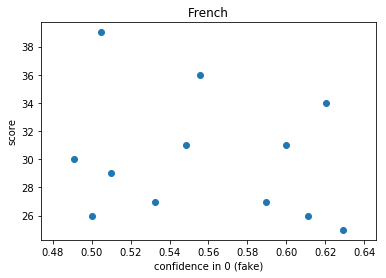

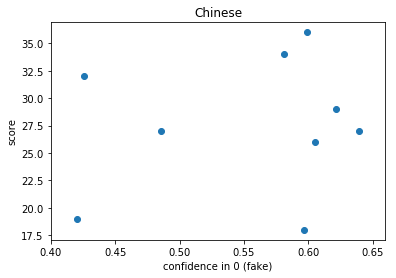

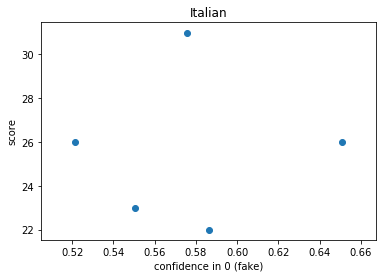

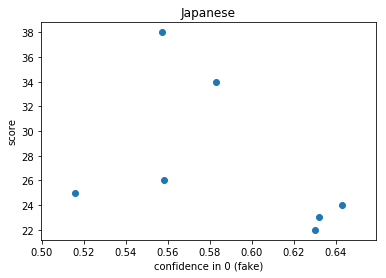

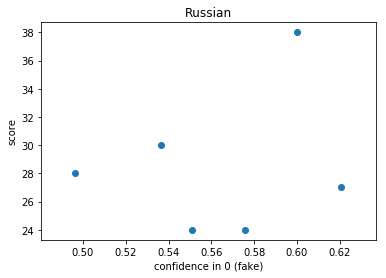

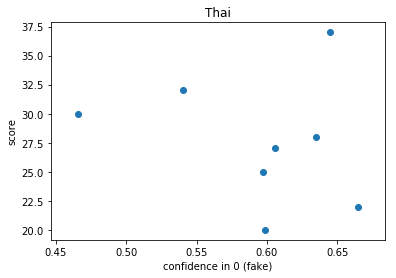

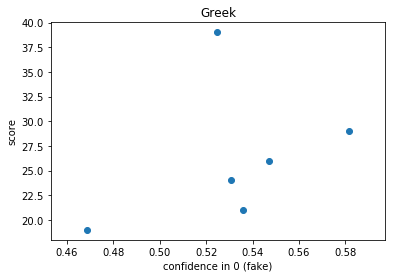

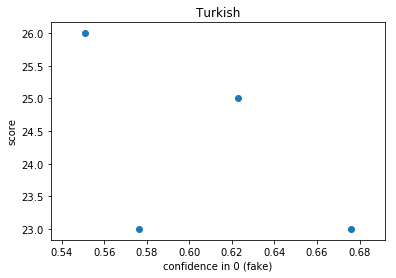

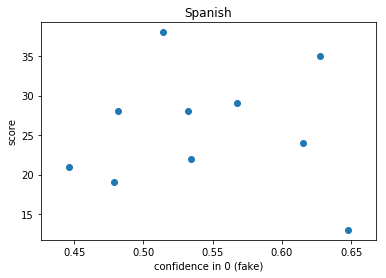

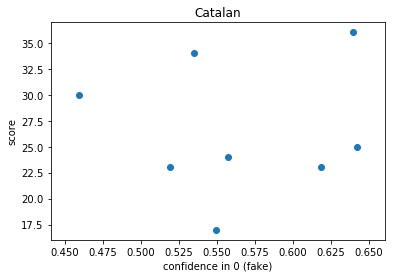

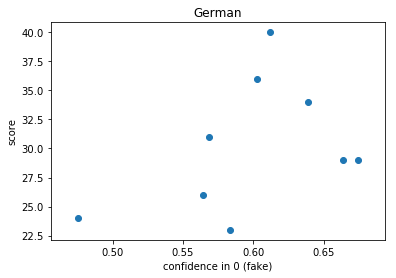

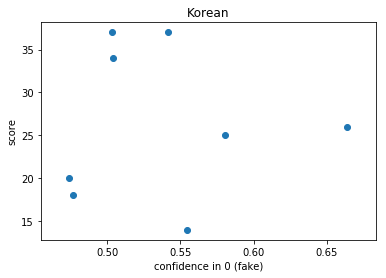

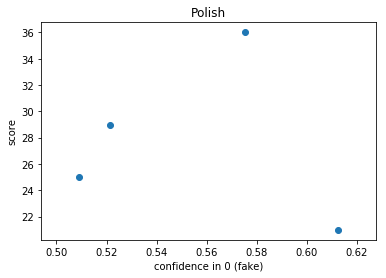

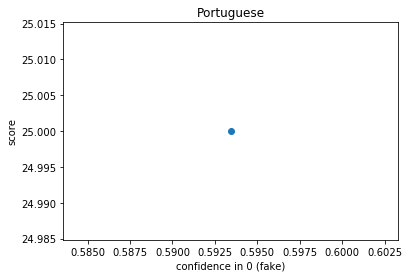

In [435]:

# Plotting datapoints for individual students based on their first language. 
# It is clear that there is not enough people in each group to be able to do any correlation -
# related to their first language.


for lang in author_and_lang.first_lang.unique():
    current = author_and_lang[author_and_lang.first_lang==lang]
    plt.scatter(current["conf_0"],current["score"])
    plt.title(lang)
    plt.xlabel("confidence in 0 (fake)")
    plt.ylabel("score")
    plt.show()

# Boxplots 

In [459]:
n_list = []
confidences_for_grades = []
grades = []
for i in sorted(author_and_lang.score.unique()):
    current = author_and_lang[author_and_lang.score==i]
    conf = current.conf_0.tolist()
    n = len(current.conf_0.tolist())
    if n >=4:
        grades.append(str(i))
        confidences_for_grades.append(conf)
        n_list.append(n)
        
    

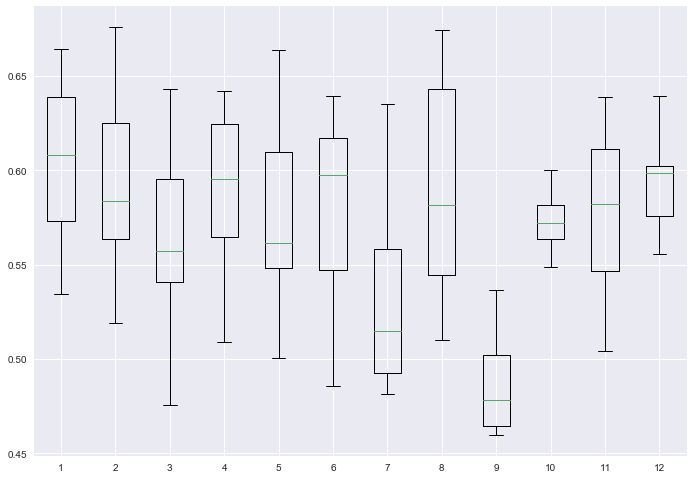

In [530]:
plt.boxplot(confidences_for_grades)
#plt.xticks(range(len(grades)),labels=grades)
plt.show()

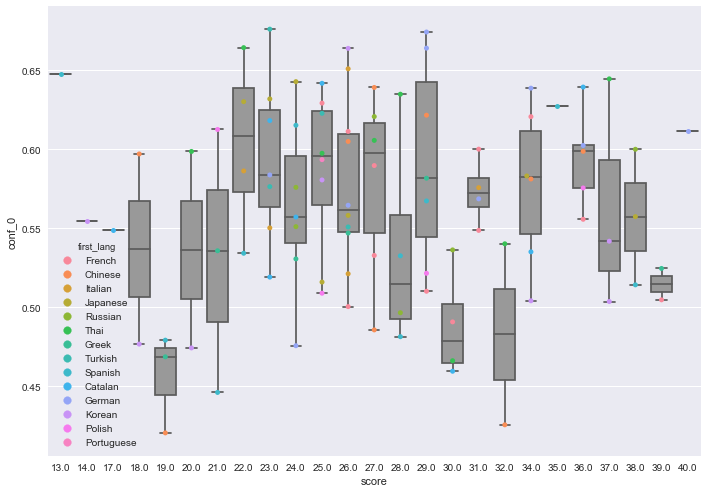

In [110]:
import seaborn as sns
#plt.rcParams.update(plt.rcParamsDefault)
#sns.set_style("whitegrid")
#plt.style.use('seaborn-whitegrid')
#sns.set_context("notebook", font_scale=20, rc={"lines.linewidth": 2.5})
#sns.set_context("paper", rc={"font.size":12,"axes.titlesize":8,"axes.labelsize":12})
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x="score", y="conf_0",data=author_and_lang, color="0.6")#hue="first_lang"
sns.swarmplot(x="score", y="conf_0", data=author_and_lang,hue="first_lang")
#plt.savefig("boxplot_conf0_langs.png", dpi=300)

### Now, only taking into account the first sentence of each author (approx. the result of having processed entire docs as one sample (with model cut off at 100 chars) instead of splitting them in sentences and processing each) :

In [98]:
l = []
for i in df_stu.ID.unique():
    first_sent = df_stu[df_stu.ID == i].iloc[0]
    l.append(first_sent)
    
df_doclevel = pd.concat([pd.DataFrame(i) for i in l], axis=1)
df_doclevel = df_doclevel.T
df_doclevel = df_doclevel[df_doclevel.score>22]
df_doclevel = df_doclevel.reset_index()
print(len(df_doclevel))
df_doclevel.head()

80


index                 ID docscore first_lang score    conf_0     conf_1  \
0     10  TE72*0100*2001*01      5.1   Japanese    38  0.927221   0.072779   
1     32  TE70*0100*2001*01      4.1      Greek    26  0.438922   0.561078   
2     76  TE31*0100*2001*01      3.1    Catalan    23  0.608441   0.391559   
3     96  TE69*0100*2001*01      4.1    Russian    28  0.923462  0.0765381   
4    151  TE25*0100*2001*01      3.2     French    26   0.90274  0.0972602   

   abs_diff  
0  0.854442  
1  0.122156  
2  0.216882  
3  0.846924  
4   0.80548

SpearmanrResult(correlation=-0.10628165615540504, pvalue=0.3480841219634403)


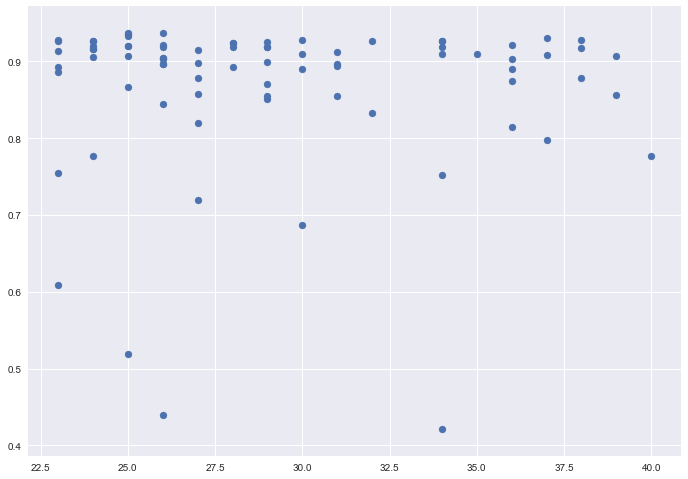

In [108]:
import seaborn as sns
#sns.set(rc={'figure.figsize':(11.7,8.27)})

#sns.boxplot(x="score", y="conf_0",data=df_doclevel, color="0.6")#hue="first_lang"
#sns.swarmplot(x="score", y="conf_0", data=df_doclevel)
#df_doclevel["score"].shape
print(stats.spearmanr(df_doclevel["docscore"], df_doclevel["conf_0"]))
plt.scatter(df_doclevel["score"], df_doclevel["conf_0"])
plt.show()

In [95]:
#temp ={"score": profvec_t[:len(teacher_preds)], "docscore":docscorevec_t[:len(teacher_preds)], 
#         "ID":useridvec_t[:len(teacher_preds)], "first_lang":langvec_t[:len(teacher_preds)]}
#df_teach = pd.DataFrame(data=temp)
#df_teach = pd.concat([df_teach, teacher_preds],  axis=1)

In [94]:
#l_t = []
#for i in df_teach.ID.unique():
#    first_sent = df_teach[df_teach.ID == i].iloc[0]
#    l_t.append(first_sent)
#df_teach_doclevel = pd.concat([pd.DataFrame(i) for i in l_t], axis=1)
#df_teach_doclevel= df_teach_doclevel.T
#sns.boxplot(x="score", y="conf_0",data=df_teach_doclevel, color="0.6")#hue="first_lang"

In [90]:
preds = []
for i in df_stu.conf_0:
    if i >0.5:
        pred = 0
    else: 
        pred = 1
    preds.append(pred)
pred_df_temp = pd.DataFrame(preds, columns=["mean_pred"])
temp2 = pd.concat([df_stu, pred_df_temp], axis=1)
temp2.drop(["abs_diff"], axis=1, inplace=True)
temp2.to_csv("all_student_scores_IDs_and_preds.csv", sep="\t")

author_gr = temp2.groupby(['ID'], as_index=False).mean()
author_gr = author_gr[author_gr.score>22]
author_gr.head()
#author_gr.drop(["abs_diff"], axis=1)
#author_gr.to_csv("grouped_by_author.csv", columns=author_gr.columns)

ID  docscore  score    conf_0    conf_1  mean_pred
0   TE1*0100*2001*01  3.588889   30.0  0.490703  0.509297   0.444444
1  TE10*0100*2001*01  3.200000   26.0  0.604944  0.395056   0.354839
2  TE11*0100*2001*01  2.748000   23.0  0.550218  0.449782   0.440000
3  TE12*0100*2001*01  3.750000   26.0  0.558114  0.441886   0.388889
4  TE13*0100*2001*01  3.300000   26.0  0.650936  0.349064   0.315789

SpearmanrResult(correlation=0.12248499910766317, pvalue=0.2790843337583912)


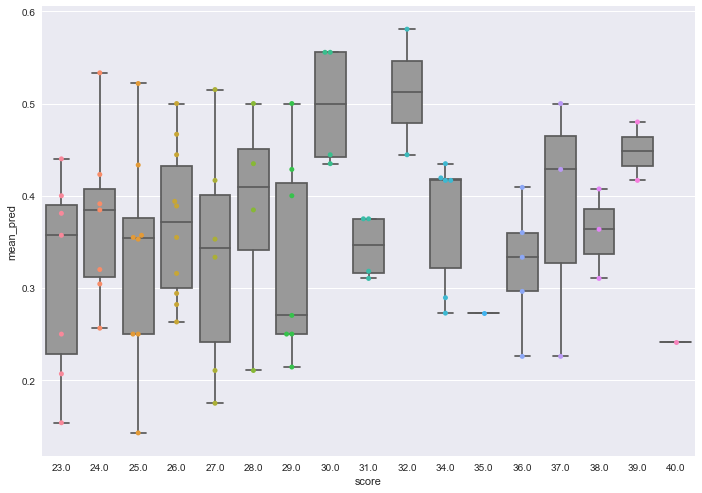

In [92]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.boxplot(x="score", y="mean_pred",data=author_gr, color="0.6", )
sns.swarmplot(x="score", y="mean_pred", data=author_gr)

print(stats.spearmanr(author_gr["docscore"], author_gr["mean_pred"]))
#print(stats.pearsonr(author_gr["score"], author_gr["pred"]))

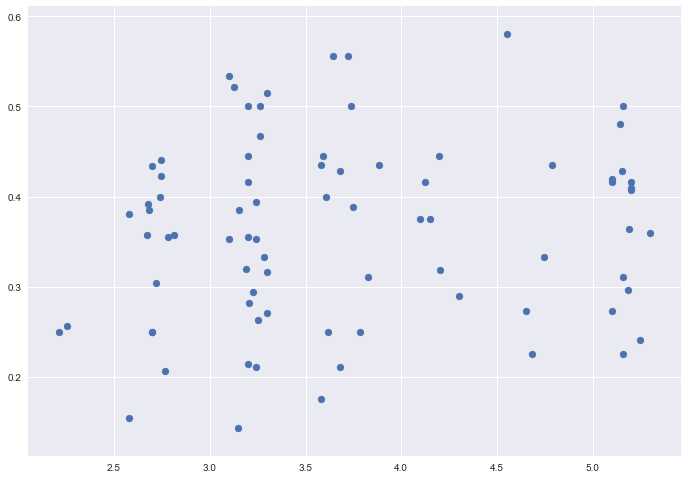

In [80]:
plt.scatter(author_gr["docscore"], author_gr["mean_pred"])

# Using prediction of entire docs, not splittet sentences

In [137]:
prof_entire_docs_students = codecs.open(path+"proficiency_entire_docs.txt", "r", "utf-8").read().split("\n")
docscore_entire_docs_students = codecs.open(path+"docscore_entire_docs.txt", "r", "utf-8").read().split("\n")
docscore_entire = []
pr_entire = []
ID_entire = []
for i,j in zip(prof_entire_docs_students[:len(prof_entire_docs_students)-1], docscore_entire_docs_students[:len(docscore_entire_docs_students)-1]):
    s = i.split("\t")
    pr_entire.append(int(float(s[0])))
    ID_entire.append(s[1])
    dscore = j.split("\t")
    docscore_entire.append(float(dscore[0][:-1]))
student_preds_entire = pd.read_csv(path+'student_preds_softmax_entire_docs.txt', sep=' ', names=['conf_0', 'conf_1'], header=None)

In [140]:
preds_entire = [1 if i >0.5 else 0 for i in student_preds_entire.conf_1]
temp_entire = {"ID": ID_entire, "proficiency_score": pr_entire, "docscore":docscore_entire, "pred":preds_entire}
temp_entire_df = pd.DataFrame(temp_entire)
df_entire = pd.concat([temp_entire_df, student_preds_entire], axis=1)

In [159]:
print(len(df_entire))
df_entire.head(10)

194


ID  docscore  pred  proficiency_score    conf_0    conf_1
0  TE23*0100*2001*01       3.0     0                 21  0.749815  0.250185
1  TE23*0100*2001*01       2.0     1                 21  0.139499  0.860501
2  TE72*0100*2001*01       5.0     0                 38  0.879496  0.120504
3  TE72*0100*2001*01       5.0     1                 38  0.467962  0.532038
4  TE70*0100*2001*01       4.0     1                 26  0.234080  0.765920
5  TE70*0100*2001*01       2.3     1                 26  0.031562  0.968438
6  TE24*0100*2001*01       3.0     1                 21  0.451902  0.548098
7  TE24*0100*2001*01       2.3     1                 21  0.071907  0.928093
8  TE31*0100*2001*01       3.0     1                 23  0.410269  0.589731
9  TE31*0100*2001*01       2.3     1                 23  0.066830  0.933170

In [180]:
entire_grouped_on_ID = df_entire.groupby(['ID'], as_index=False).mean()
entire_grouped_on_ID = entire_grouped_on_ID[(entire_grouped_on_ID.proficiency_score>22)] # no grades below 22
entire_grouped_on_ID

ID  docscore  pred  proficiency_score    conf_0    conf_1
0    TE1*0100*2001*01      3.65   1.0               30.0  0.209256  0.790744
1   TE10*0100*2001*01      3.00   1.0               26.0  0.183762  0.816238
2   TE11*0100*2001*01      2.50   0.5               23.0  0.334956  0.665044
3   TE12*0100*2001*01      3.50   0.0               26.0  0.835729  0.164271
4   TE13*0100*2001*01      3.00   0.0               26.0  0.669606  0.330394
5   TE14*0100*2001*01      5.00   0.0               38.0  0.833534  0.166466
6   TE15*0100*2001*01      3.15   0.0               27.0  0.621062  0.378938
7   TE16*0100*2001*01      5.00   0.5               39.0  0.478470  0.521530
8   TE17*0100*2001*01      2.50   0.0               25.0  0.742362  0.257638
9   TE18*0100*2001*01      2.00   0.0               24.0  0.779091  0.220909
10  TE19*0100*2001*01      2.50   0.0               25.0  0.719205  0.280795
11   TE2*0100*2001*01      3.00   0.5               27.0  0.442069  0.557931
12  TE20*0100*2001*01      3.50   0.5               30.0  0.435130  0.564870
13  TE21*0100*2001*01      3.50   0.0               27.0  0.708197  0.291803
17  TE25*0100*2001*01      3.00   0.5               26.0  0.572342  0.427658
19  TE27*0100*2001*01      2.50   0.5               24.0  0.468425  0.531575
20  TE28*0100*2001*01      5.00   0.5               38.0  0.445084  0.554916
21  TE29*0100*2001*01      3.50   0.0               30.0  0.769523  0.230477
22   TE3*0100*2001*01      5.00   0.5               34.0  0.423993  0.576007
23  TE30*0100*2001*01      3.00   0.5               24.0  0.476054  0.523946
24  TE31*0100*2001*01      2.65   1.0               23.0  0.238549  0.761451
26  TE33*0100*2001*01      2.50   0.5               23.0  0.502666  0.497334
27  TE34*0100*2001*01      5.00   0.0               39.0  0.764674  0.235326
28  TE35*0100*2001*01      4.50   0.0               34.0  0.724242  0.275758
29  TE36*0100*2001*01      5.00   0.0               37.0  0.575500  0.424500
30  TE37*0100*2001*01      4.00   0.5               31.0  0.478161  0.521839
31  TE38*0100*2001*01      3.00   0.0               28.0  0.743247  0.256753
32  TE39*0100*2001*01      3.00   0.0               26.0  0.734347  0.265653
33   TE4*0100*2001*01      3.50   0.0               29.0  0.740992  0.259008
34  TE40*0100*2001*01      4.00   0.5               34.0  0.484363  0.515637
..                ...       ...   ...                ...       ...       ...
62  TE66*0100*2001*01      3.00   1.0               29.0  0.419526  0.580474
63  TE67*0100*2001*01      4.00   0.0               31.0  0.587331  0.412669
64  TE68*0100*2001*01      2.50   0.0               23.0  0.681122  0.318878
65  TE69*0100*2001*01      3.50   0.5               28.0  0.465439  0.534561
66   TE7*0100*2001*01      3.00   0.0               26.0  0.733632  0.266368
67  TE70*0100*2001*01      3.15   1.0               26.0  0.132821  0.867179
69  TE72*0100*2001*01      5.00   0.5               38.0  0.673729  0.326271
70  TE73*0100*2001*01      4.00   0.5               32.0  0.440319  0.559681
71  TE74*0100*2001*01      3.50   0.5               29.0  0.428106  0.571894
72  TE75*0100*2001*01      5.00   0.5               36.0  0.504724  0.495276
73  TE76*0100*2001*01      5.00   0.5               40.0  0.541978  0.458022
74  TE77*0100*2001*01      3.65   0.0               29.0  0.725306  0.274694
75  TE78*0100*2001*01      5.00   0.5               34.0  0.477217  0.522783
76  TE79*0100*2001*01      5.00   0.5               36.0  0.573638  0.426362
77   TE8*0100*2001*01      2.65   0.0               25.0  0.700293  0.299707
78  TE80*0100*2001*01      5.00   0.5               37.0  0.303580  0.696420
80  TE82*0100*2001*01      4.50   1.0               32.0  0.217546  0.782454
81  TE83*0100*2001*01      3.00   0.5               25.0  0.508330  0.491670
82  TE84*0100*2001*01      3.15   0.0               25.0  0.777671  0.222329
83  TE85*0100*2001*01      4.50   0.5               36.0  0.568440  0.431560
84  TE86*0100*2

SpearmanrResult(correlation=0.049108386845761465, pvalue=0.6653148647922628)


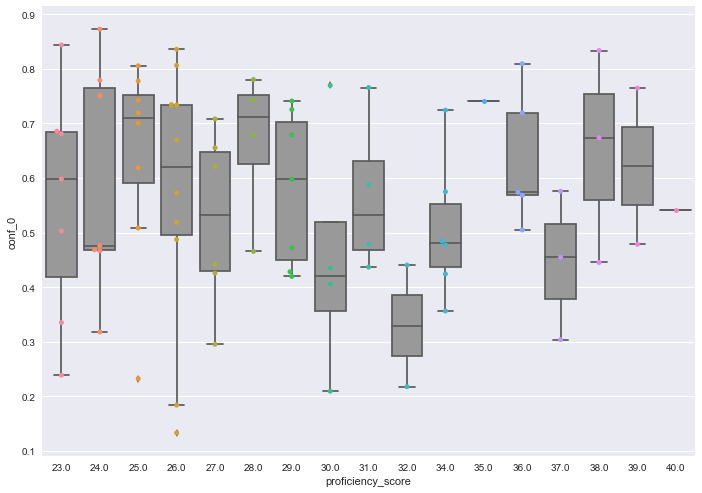

In [181]:
sns.boxplot(x="proficiency_score", y="conf_0",data=entire_grouped_on_ID, color="0.6", )
sns.swarmplot(x="proficiency_score", y="conf_0", data=entire_grouped_on_ID)

print(stats.spearmanr(entire_grouped_on_ID["proficiency_score"], entire_grouped_on_ID["pred"]))